In [14]:
!pip install tensorflow numpy matplotlib scikit-learn --quiet


In [15]:
# Download the dataset zip file
!curl -L -o ~/pet_disease.zip https://www.kaggle.com/api/v1/datasets/download/smadive/pet-disease-images

# Create directory
!mkdir -p ~/pet_disease_data

# Extract
!unzip -q ~/pet_disease.zip -d ~/pet_disease_data


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  403M  100  403M    0     0  18.6M      0  0:00:21  0:00:21 --:--:-- 21.1M


In [ ]:
import os
import shutil
import random

data_path = os.path.expanduser("~/pet_disease_data/data")
print("Raw dataset folders:", os.listdir(data_path))

print("Before renaming:", os.listdir(data_path))

for root, dirs, files in os.walk(data_path):
    for d in dirs:
        if " " in d:
            old_path = os.path.join(root, d)
            new_name = d.replace(" ", "_")
            new_path = os.path.join(root, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: '{d}' → '{new_name}'")

print("After renaming:", os.listdir(data_path))

train_dir = os.path.join(data_path, "train")
test_dir  = os.path.join(data_path, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

class_folders = [f for f in os.listdir(data_path)
                 if os.path.isdir(os.path.join(data_path, f))
                 and f not in ["train", "test"]]

print("Detected class folders:", class_folders)

for cls in class_folders:
    src_folder = os.path.join(data_path, cls)
    images = os.listdir(src_folder)

    random.shuffle(images)

    split_idx = int(len(images) * 0.8)
    train_imgs = images[:split_idx]
    test_imgs  = images[split_idx:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls),  exist_ok=True)

    for img in train_imgs:
        shutil.move(os.path.join(src_folder, img),
                    os.path.join(train_dir, cls, img))

    for img in test_imgs:
        shutil.move(os.path.join(src_folder, img),
                    os.path.join(test_dir, cls, img))

    shutil.rmtree(src_folder)

print("🎉 Dataset successfully split into train/ and test/")
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


📁 Raw dataset folders: ['train', 'Ear Mites in Cat', 'Dental Disease in Dog', 'Mange in Dog', 'Ringworm in Cat', 'Worm Infection in Dog', 'Parvovirus in Dog', 'Skin Allergy in Cat', 'Eye Infection in Dog', 'Skin Allergy in Dog', 'Feline Leukemia', 'Kennel Cough in Dog', 'Feline Panleukopenia', 'Worm Infection in Cat', 'Hot Spots in Dog', 'Distemper in Dog', 'Fungal Infection in Cat', 'Tick Infestation in Dog', 'Fungal Infection in Dog', 'Urinary Tract Infection in Cat', 'Dental Disease in Cat', 'Eye Infection in Cat', 'Scabies in Cat', 'test']
Before renaming: ['train', 'Ear Mites in Cat', 'Dental Disease in Dog', 'Mange in Dog', 'Ringworm in Cat', 'Worm Infection in Dog', 'Parvovirus in Dog', 'Skin Allergy in Cat', 'Eye Infection in Dog', 'Skin Allergy in Dog', 'Feline Leukemia', 'Kennel Cough in Dog', 'Feline Panleukopenia', 'Worm Infection in Cat', 'Hot Spots in Dog', 'Distemper in Dog', 'Fungal Infection in Cat', 'Tick Infestation in Dog', 'Fungal Infection in Dog', 'Urinary Tract 

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Detected classes:", train_gen.class_indices)


Found 1609 images belonging to 22 classes.
Found 620 images belonging to 22 classes.
Detected classes: {'Dental_Disease_in_Cat': 0, 'Dental_Disease_in_Dog': 1, 'Distemper_in_Dog': 2, 'Ear_Mites_in_Cat': 3, 'Eye_Infection_in_Cat': 4, 'Eye_Infection_in_Dog': 5, 'Feline_Leukemia': 6, 'Feline_Panleukopenia': 7, 'Fungal_Infection_in_Cat': 8, 'Fungal_Infection_in_Dog': 9, 'Hot_Spots_in_Dog': 10, 'Kennel_Cough_in_Dog': 11, 'Mange_in_Dog': 12, 'Parvovirus_in_Dog': 13, 'Ringworm_in_Cat': 14, 'Scabies_in_Cat': 15, 'Skin_Allergy_in_Cat': 16, 'Skin_Allergy_in_Dog': 17, 'Tick_Infestation_in_Dog': 18, 'Urinary_Tract_Infection_in_Cat': 19, 'Worm_Infection_in_Cat': 20, 'Worm_Infection_in_Dog': 21}


In [19]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,250,326 (84.88 MB)

 Trainable params: 22,250,326 (84.88 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_pet_disease_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    callbacks=[checkpoint]
)



Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.0536 - loss: 3.4920
Epoch 1: val_accuracy improved from -inf to 0.06290, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 943ms/step - accuracy: 0.0535 - loss: 3.4866 - val_accuracy: 0.0629 - val_loss: 3.0828
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.0465 - loss: 3.0842
Epoch 2: val_accuracy improved from 0.06290 to 0.07419, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 838ms/step - accuracy: 0.0466 - loss: 3.0841 - val_accuracy: 0.0742 - val_loss: 3.0463
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.0733 - loss: 3.0504
Epoch 3: val_accuracy improved from 0.07419 to 0.09194, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 898ms/step - accuracy: 0.0735 - loss: 3.0503 - val_accuracy: 0.0919 - val_loss: 3.0287
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.0839 - loss: 3.0173
Epoch 4: val_accuracy improved from 0.09194 to 0.10323, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 881ms/step - accuracy: 0.0840 - loss: 3.0172 - val_accuracy: 0.1032 - val_loss: 2.9645
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.0926 - loss: 3.0067
Epoch 5: val_accuracy did not improve from 0.10323
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 886ms/step - accuracy: 0.0927 - loss: 3.0066 - val_accuracy: 0.0919 - val_loss: 2.9550
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.1098 - loss: 2.9583
Epoch 6: val_accuracy improved from 0.10323 to 0.11613, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 958ms/step - accuracy: 0.1098 - loss: 2.9584 - val_accuracy: 0.1161 - val_loss: 2.9287
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.1109 - loss: 2.9604
Epoch 7: val_accuracy did not improve from 0.11613
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 834ms/step - accuracy: 0.1109 - loss: 2.9606 - val_accuracy: 0.1129 - val_loss: 2.9874
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.1366 - loss: 2.8988
Epoch 8: val_accuracy improved from 0.11613 to 0.16290, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 929ms/step - accuracy: 0.1365 - loss: 2.8992 - val_accuracy: 0.1629 - val_loss: 2.8795
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.1263 - loss: 2.9045
Epoch 9: val_accuracy did not improve from 0.16290
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 814ms/step - accuracy: 0.1263 - loss: 2.9046 - val_accuracy: 0.1613 - val_loss: 2.8675
Epoch 10/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.1255 - loss: 2.9119
Epoch 10: val_accuracy improved from 0.16290 to 0.18226, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 998ms/step - accuracy: 0.1257 - loss: 2.9114 - val_accuracy: 0.1823 - val_loss: 2.8132
Epoch 11/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.1287 - loss: 2.9050
Epoch 11: val_accuracy improved from 0.18226 to 0.18548, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 958ms/step - accuracy: 0.1289 - loss: 2.9046 - val_accuracy: 0.1855 - val_loss: 2.8120
Epoch 12/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.1730 - loss: 2.8039
Epoch 12: val_accuracy did not improve from 0.18548
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 811ms/step - accuracy: 0.1728 - loss: 2.8046 - val_accuracy: 0.1548 - val_loss: 2.8613
Epoch 13/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.1645 - loss: 2.8304
Epoch 13: val_accuracy improved from 0.18548 to 0.23387, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1644 - loss: 2.8305 - val_accuracy: 0.2339 - val_loss: 2.6472
Epoch 14/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.1616 - loss: 2.7858
Epoch 14: val_accuracy improved from 0.23387 to 0.23548, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 930ms/step - accuracy: 0.1618 - loss: 2.7858 - val_accuracy: 0.2355 - val_loss: 2.6089
Epoch 15/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.1845 - loss: 2.7476
Epoch 15: val_accuracy did not improve from 0.23548
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 817ms/step - accuracy: 0.1844 - loss: 2.7477 - val_accuracy: 0.2306 - val_loss: 2.7057
Epoch 16/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.1844 - loss: 2.7263
Epoch 16: val_accuracy did not improve from 0.23548
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - accuracy: 0.1843 - loss: 2.7269 - val_accuracy: 0.2113 - val_loss: 2.6522
Epoch 17/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.2051 - loss: 2.6999
Epoch 17: val_accuracy improved from 0.23548 to 0.27258, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.2049 - loss: 2.6998 - val_accuracy: 0.2726 - val_loss: 2.4898
Epoch 18/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.1856 - loss: 2.6797
Epoch 18: val_accuracy improved from 0.27258 to 0.28387, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 946ms/step - accuracy: 0.1857 - loss: 2.6799 - val_accuracy: 0.2839 - val_loss: 2.4707
Epoch 19/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.2131 - loss: 2.6107
Epoch 19: val_accuracy did not improve from 0.28387
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 814ms/step - accuracy: 0.2130 - loss: 2.6114 - val_accuracy: 0.2613 - val_loss: 2.4873
Epoch 20/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.2427 - loss: 2.6271
Epoch 20: val_accuracy improved from 0.28387 to 0.31774, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2423 - loss: 2.6273 - val_accuracy: 0.3177 - val_loss: 2.4082
Epoch 21/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.2270 - loss: 2.5879
Epoch 21: val_accuracy did not improve from 0.31774
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 809ms/step - accuracy: 0.2269 - loss: 2.5884 - val_accuracy: 0.3161 - val_loss: 2.3649
Epoch 22/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.2481 - loss: 2.4891
Epoch 22: val_accuracy improved from 0.31774 to 0.32097, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 943ms/step - accuracy: 0.2478 - loss: 2.4902 - val_accuracy: 0.3210 - val_loss: 2.3318
Epoch 23/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.2580 - loss: 2.4642
Epoch 23: val_accuracy improved from 0.32097 to 0.36935, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 933ms/step - accuracy: 0.2579 - loss: 2.4646 - val_accuracy: 0.3694 - val_loss: 2.2085
Epoch 24/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.2652 - loss: 2.4345
Epoch 24: val_accuracy improved from 0.36935 to 0.37419, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.2651 - loss: 2.4351 - val_accuracy: 0.3742 - val_loss: 2.1740
Epoch 25/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.2676 - loss: 2.4650
Epoch 25: val_accuracy did not improve from 0.37419
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 813ms/step - accuracy: 0.2678 - loss: 2.4646 - val_accuracy: 0.3629 - val_loss: 2.1958
Epoch 26/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.2744 - loss: 2.4051
Epoch 26: val_accuracy improved from 0.37419 to 0.39032, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 977ms/step - accuracy: 0.2744 - loss: 2.4055 - val_accuracy: 0.3903 - val_loss: 2.1514
Epoch 27/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.3072 - loss: 2.3279
Epoch 27: val_accuracy improved from 0.39032 to 0.39355, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 965ms/step - accuracy: 0.3069 - loss: 2.3283 - val_accuracy: 0.3935 - val_loss: 2.0964
Epoch 28/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.2819 - loss: 2.3815
Epoch 28: val_accuracy improved from 0.39355 to 0.40484, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2820 - loss: 2.3813 - val_accuracy: 0.4048 - val_loss: 2.0924
Epoch 29/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.3106 - loss: 2.2968
Epoch 29: val_accuracy improved from 0.40484 to 0.40968, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 980ms/step - accuracy: 0.3105 - loss: 2.2973 - val_accuracy: 0.4097 - val_loss: 2.1264
Epoch 30/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.3254 - loss: 2.2608
Epoch 30: val_accuracy improved from 0.40968 to 0.42742, saving model to best_pet_disease_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 950ms/step - accuracy: 0.3253 - loss: 2.2610 - val_accuracy: 0.4274 - val_loss: 1.9752


In [21]:
from google.colab import files

files.download("best_pet_disease_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

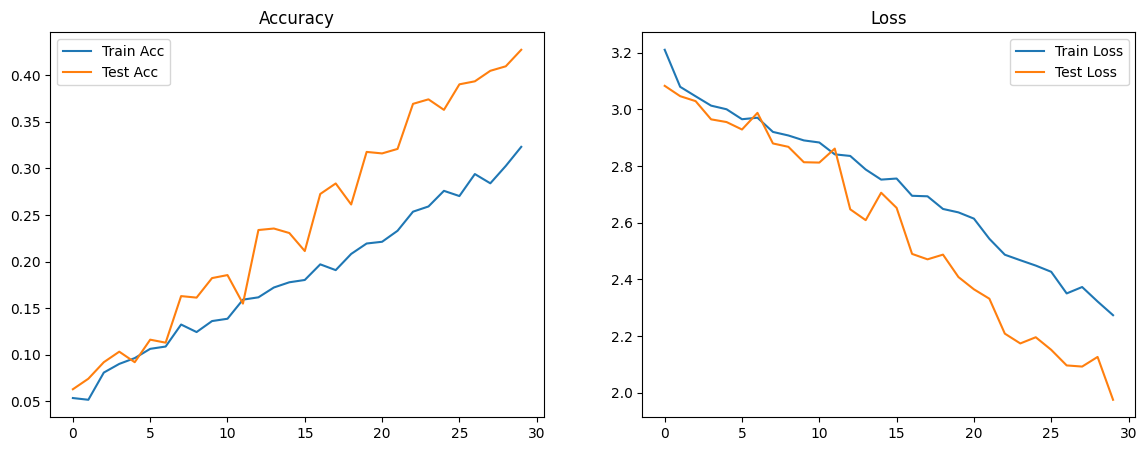

In [22]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Test Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.title("Loss")
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


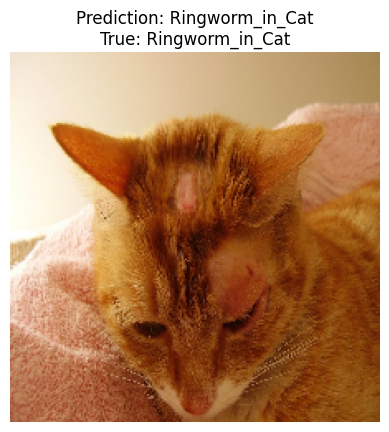

In [23]:
import random, os
from tensorflow.keras.preprocessing import image

cls = random.choice(os.listdir(test_dir))
img_name = random.choice(os.listdir(os.path.join(test_dir, cls)))
img_path = os.path.join(test_dir, cls, img_name)

img = image.load_img(img_path, target_size=IMG_SIZE)
img_arr = image.img_to_array(img)/255.
img_arr = np.expand_dims(img_arr, 0)

pred = model.predict(img_arr)
pred_class = list(train_gen.class_indices.keys())[np.argmax(pred)]

plt.imshow(img)
plt.title(f"Prediction: {pred_class}\nTrue: {cls}")
plt.axis("off")
plt.show()
